In [90]:
# Imports
import math
import os

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

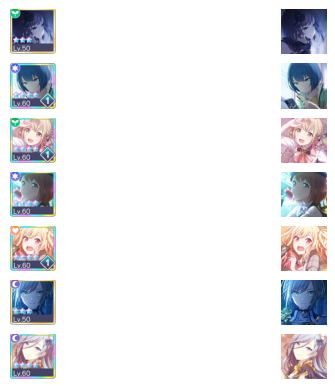

In [91]:
# Some manually matched thumbnails
matching_images = [
    ("./img/ena.png", "./thumbnails/res019_no014_after_training.png"),
    ("./img/haruka.png", "./thumbnails/res006_no017_normal.png"),
    ("./img/kohane.png", "./thumbnails/res009_no007_after_training.png"),
    ("./img/minori.png", "./thumbnails/res005_no015_after_training.png"),
    ("./img/saki.png", "./thumbnails/res002_no015_normal.png"),
    ("./img/shiho.png", "./thumbnails/res004_no016_after_training.png"),
    ("./img/shizuku.png", "./thumbnails/res008_no008_after_training.png"),
]

cols = 2
rows = len(matching_images)

fig, axes = plt.subplots(rows, cols)

for i in range(rows):
    extracted = cv.imread(matching_images[i][0])
    axes[i, 0].set_axis_off()
    axes[i, 0].imshow(extracted[..., ::-1])

    reference = cv.imread(matching_images[i][1])
    axes[i, 1].set_axis_off()
    axes[i, 1].imshow(reference[..., ::-1])

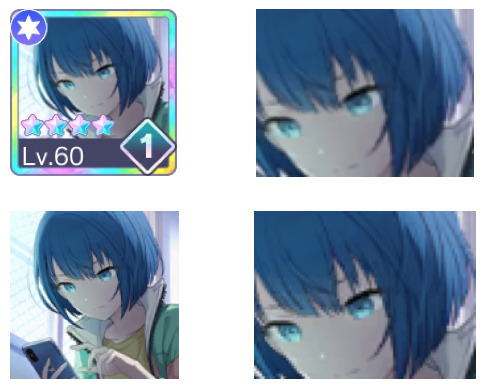

In [92]:
# Like with the colour histograms, we need to crop the thumbnail to exclude additional elements
# Manually cropping Haruka's thumbnail (157x157px) shows that we need to remove:
# - ~10px from top (6.3%)
# - ~60px from bottom (38.2%)
# - ~35px from left (22.3%)
# - ~10px from right (6.3%)
#
# To make calculations easier, these can be rounded up to:
# - 10% from top
# - 40% from bottom
# - 25% from left
# - 10% from right
def crop_thumbnail_for_hash(img_thumbnail, ratio_top=0.1, ratio_bot=0.4, ratio_left=0.25, ratio_right=0.1):
    (h, w, _) = img_thumbnail.shape

    top = math.ceil(h * ratio_top)
    bot = math.ceil(h * ratio_bot)
    left = math.ceil(w * ratio_left)
    right = math.ceil(w * ratio_right)

    return img_thumbnail[top:-bot, left:-right]

img_haruka_ext = cv.imread(matching_images[1][0])
img_haruka_ref = cv.imread(matching_images[1][1])

img_haruka_ext_crop = crop_thumbnail_for_hash(img_haruka_ext)
img_haruka_ref_crop = crop_thumbnail_for_hash(img_haruka_ref)

fig, axes = plt.subplots(2, 2)

axes[0, 0].set_axis_off()
axes[0, 0].imshow(img_haruka_ext[..., ::-1])

axes[1, 0].set_axis_off()
axes[1, 0].imshow(img_haruka_ref[..., ::-1])

axes[0, 1].set_axis_off()
axes[0, 1].imshow(img_haruka_ext_crop[..., ::-1])

axes[1, 1].set_axis_off()
axes[1, 1].imshow(img_haruka_ref_crop[..., ::-1])

In [93]:
# The output from pHash is an array of 8 8-bit numbers, making this a 64-bit hash
# For easier storage, we could store as a single 64-bit integer
phash_haruka_ext_arr = cv.img_hash.pHash(img_haruka_ext_crop)
phash_haruka_ref_arr = cv.img_hash.pHash(img_haruka_ref_crop)

phash_haruka_ext = phash_haruka_ext_arr.flatten().view("uint64")[0]
phash_haruka_ref = phash_haruka_ref_arr.flatten().view("uint64")[0]

print("Extracted:", bin(phash_haruka_ext))
print("Reference:", bin(phash_haruka_ref))

# Once we have the hashes, we can compute hamming distance to see how well they match
# The extracted thumbnail matches pretty well
print("Hamming Distance:", (phash_haruka_ext ^ phash_haruka_ref).bit_count())

Extracted: 0b1000110111110001000000111111110001010111101000010111110010010111
Reference: 0b1000110111111001000100111111110001010111101000010110110010010111
Hamming Distance: 3


In [94]:
# Computing p-hashes for all of the reference thumbnails
# This runs quite quickly, considering that there are a few thousand of them being loaded from disk
# In practice, these hashes only have to be computed once per thumbnail, unless the cropping changes
def compute_thumbnail_phash(img_thumbnail):
    img_cropped = crop_thumbnail_for_hash(img_thumbnail)
    phash_arr = cv.img_hash.pHash(img_cropped)
    return phash_arr.flatten().view("uint64")[0]

reference_phashes = {}

for root, _, filenames in os.walk("./thumbnails"):
    for filename in filenames:
        filepath = os.path.join(root, filename)
        img_ref = cv.imread(filepath)
        phash = compute_thumbnail_phash(img_ref)

        reference_phashes[filepath] = phash

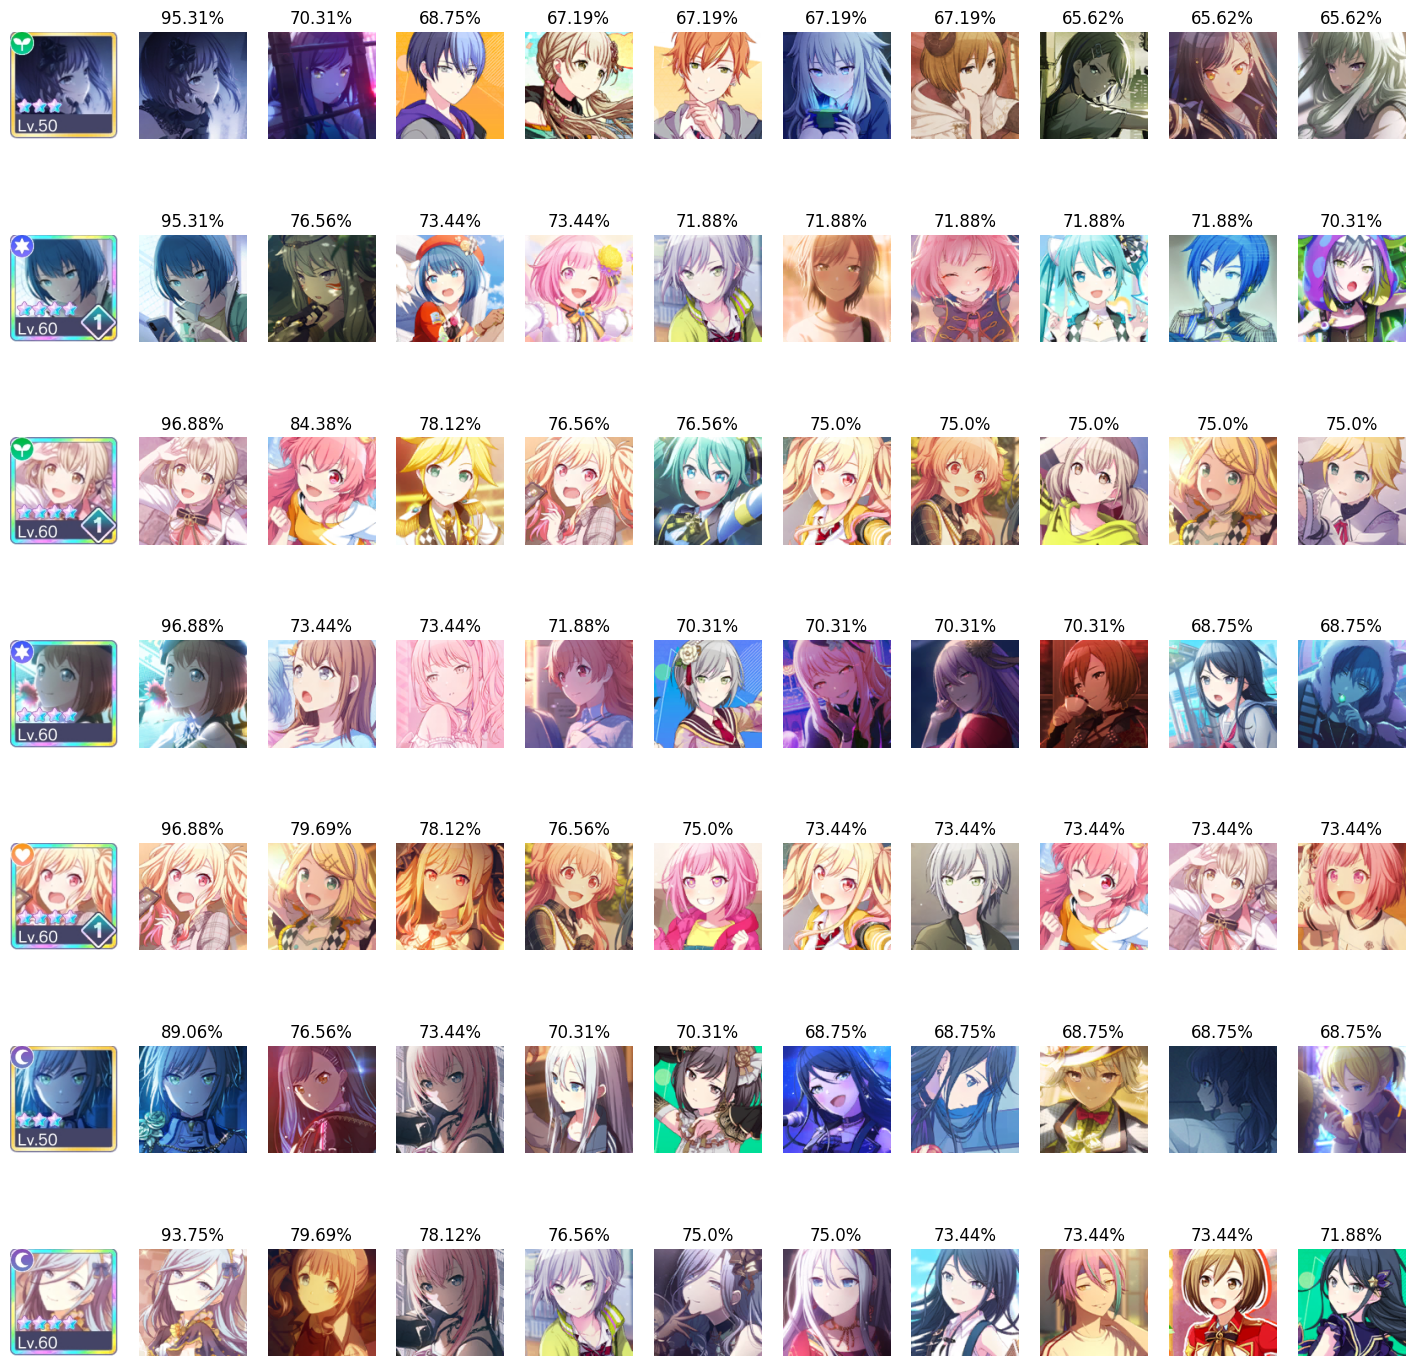

In [96]:
# Finding the top-n thumbnails using Hamming distance and linear search
# The speed isn't bad and there are no mismatches, despite having to lookup every combination
# If the pyplot calls are commented out, this runs almost instantly
def hamming_distance(a, b):
    return (a ^ b).bit_count()

def confidence(hamming_distance, max=64):
    return 1.0 - (hamming_distance / max)

def find_top_n_thumbnails(img_thumbnail, reference_phashes, n=10):
    phash = compute_thumbnail_phash(img_thumbnail)
    thumbnail_distances = []

    for path, phash_ref in reference_phashes.items():
        distance = hamming_distance(phash, phash_ref)
        thumbnail_distances.append((path, distance))

    thumbnail_distances.sort(key=lambda x: x[1])
    return thumbnail_distances[:n]

max_matches = 10

rows = len(matching_images)
cols = 1 + max_matches

fig, axes = plt.subplots(rows, cols, figsize=(18, 18))

for i in range(rows):
    img_ext = cv.imread(matching_images[i][0])
    thumbnail_distances = find_top_n_thumbnails(img_ext, reference_phashes, max_matches)

    axes[i, 0].set_axis_off()
    axes[i, 0].imshow(img_ext[..., ::-1])

    for j in range(1, cols):
        (filepath_match, distance) = thumbnail_distances[j-1]
        img_match = cv.imread(filepath_match)

        axes[i, j].set_axis_off()
        axes[i, j].set_title("{}%".format(round(confidence(distance) * 100, 2)))
        axes[i, j].imshow(img_match[..., ::-1])